In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, resnet34, resnet50
from torch import einsum
from einops import rearrange, repeat
import matplotlib.pyplot as plt

In [22]:
from PIL import Image
import numpy as np

img=Image.open('../CNN Transformer/Her2Neg_Case_02_74_100.png')
img=np.array(img)
img=torch.from_numpy(img)

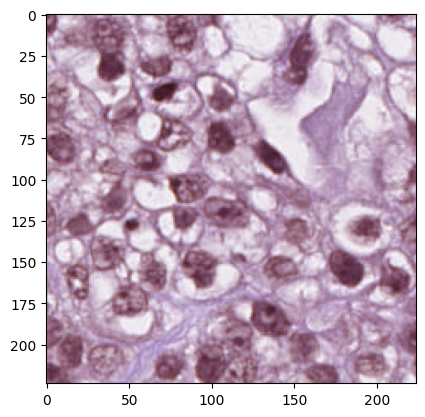

In [4]:
plt.imshow(img)

In [5]:
img=img.permute(2,0,1)

In [6]:
img=img.unsqueeze(0)
img.shape

torch.Size([1, 3, 224, 224])

In [7]:
class CNN_BackBone(nn.Module):
    def __init__(self, backbone, pretrained=True):
        super().__init__()
        self.backbone = backbone
        self.pretrained = pretrained

        if self.backbone=='resnet18':
            self.model = resnet18(pretrained=self.pretrained)
        elif self.backbone=='resnet34':
            self.model = resnet34(pretrained=self.pretrained)
        elif self.backbone=='resnet50':
            self.model = resnet50(pretrained=self.pretrained)
        
        self.model = nn.Sequential(*list(self.model.children())[:-2])


    def forward(self,x):
        return self.model(x)

In [8]:
model=CNN_BackBone('resnet18')

c:\Users\madhava\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\madhava\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
model.model

NameError: name 'model' is not defined

In [10]:
model=nn.Sequential(
    nn.Conv2d(3,64,7)
)

In [11]:
a1= torch.randn(1,3,224,224)
b=model(a1)

In [12]:
class transposeConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def init_weights(self):
        nn.init.kaming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.conv.bias, 0)
         
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [13]:
class ConvTransposeModule(nn.Module):
    def __init__(self, in_channels, output_channels, kernel_size, stride, padding):
        
        super().__init__()
        self.relu=nn.GELU()

        # 512 -> 256
        self.conv1 = transposeConv(in_channels, output_channels, kernel_size, stride, padding)

        # 256 -> 128

        self.conv2 = transposeConv(output_channels, output_channels//2, kernel_size, stride, padding)

        # 128 -> 64

        self.conv3 = transposeConv(output_channels//2, output_channels//4, kernel_size, stride, padding)

        # 64 -> 32

        self.conv4 = transposeConv(output_channels//4, output_channels//8, kernel_size, stride, padding)

        # 32 -> 3

        self.conv5 = transposeConv(output_channels//8, 3, kernel_size, stride, padding)



    def forward(self, x):
        x = self.conv1(x)
        x=self.relu(x)
        x = self.conv2(x)
        x=self.relu(x)
        x = self.conv3(x)
        x=self.relu(x)
        x = self.conv4(x)
        x=self.relu(x)
        x = self.conv5(x)
        return x
    

In [14]:
model=ConvTransposeModule(512, 256, 4, 2, 1)

In [15]:
class CNN_BACK_BONE(nn.Module):

    def __init__(self, backbone, convtranspose):
        
        super().__init__()
        self.backbone = backbone
        self.convtranspose = convtranspose
        self.norm=nn.BatchNorm2d(3)
    
    def forward(self, x):
        first=x
        x=self.backbone(x)
        x=self.convtranspose(x)

        return self.norm(first+x)


In [16]:
backbone=CNN_BackBone('resnet18')
convtranspose=ConvTransposeModule(512, 256, 4, 2, 1)

In [17]:
total=CNN_BACK_BONE(backbone, convtranspose)